In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dropout
from keras import regularizers, optimizers
from keras.layers import Input, Conv1D, Dense, Flatten, Activation, UpSampling1D, MaxPooling1D, ZeroPadding1D, TimeDistributed
from keras.models import Model, load_model
from keras.layers.core import Reshape

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model


# Dataset
We use the ECG dataset available [here](https://www.kaggle.com/shayanfazeli/heartbeat/data?select=mitbih_train.csv). There is [an article](https://arxiv.org/pdf/1805.00794.pdf) that uses the dataset, which we can use as a reference. More details about the dataset can be found [here](https://physionet.org/content/apnea-ecg/1.0.0/)

1. Train only on normal cases. --> determine average error.
2. Use the error as the threshold for decisions
3. Check if the error differs significantly for other classes.

## Load the datasets

In [2]:
train = pd.read_csv('datasets/mitbih_train/mitbih_train.csv', low_memory=False, header=None)
train.shape

(87554, 188)

In [3]:
test = pd.read_csv('datasets/mitbih_test/mitbih_test.csv', low_memory=False, header=None)
test.shape

(21892, 188)

In [6]:
normal = pd.read_csv('datasets/ptbdb_normal/ptbdb_normal.csv',low_memory=False, header=None)
normal.shape

(4046, 188)

In [ ]:
abnormal = pd.read_csv('datasets/ptbdb_abnormal/ptbdb_abnormal.csv', low_memory=False, header=None)
abnormal.shape

## Split into X and y

In [16]:
# Train data
X_train = train.to_numpy()[:,0:186]
y_train = train.to_numpy()[:,-1]#.reshape(-1,1)

X_train=X_train.reshape(-1,186,1)

X_train_normal = X_train[y_train == 0]
#X_train_normal = X_train_normal[0:5000]
X_train_anomaly = X_train[y_train== 1]
X_train_anomaly2 = X_train[y_train== 2]
X_train_anomaly3 = X_train[y_train== 3]
X_train_anomaly4 = X_train[y_train== 4]


# TEST data
X_test = test.to_numpy()[:,0:186]
y_test = test.to_numpy()[:,-1]#.reshape(-1,1)

X_test_normal = X_test[y_test == 0]
X_test_anomaly = X_test[y_test == 1]
X_test_anomaly2 = X_test[y_test == 2]
X_test_anomaly3 = X_test[y_test == 3]
X_test_anomaly4 = X_test[y_test == 4]

In [17]:
X_train.shape

(87554, 186, 1)

In [18]:
X_train_normal.shape

(72471, 186, 1)

## Train

In [19]:
def LSTM_AE(input_shape):

    inputs = Input(shape=input_shape)
    encoded = LSTM(32, activation='tanh', return_sequences=True)(inputs)
    encoded = LSTM(16, activation='tanh', return_sequences=False)(encoded)

    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(16, activation='tanh', return_sequences=True)(decoded)
    decoded = LSTM(32, activation='tanh', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)

    sequence_autoencoder = Model(inputs, decoded)

    return sequence_autoencoder

In [20]:
model = LSTM_AE((186,1))
model.summary()
model.compile(optimizer='adam', loss='mae', metrics=None)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 186, 1)]          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 186, 32)           4352      
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 186, 16)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 186, 16)           2112      
_________________________________________________________________
lstm_11 (LSTM)               (None, 186, 32)           6272      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 186, 1)            33  

In [21]:
history = model.fit(X_train_normal, X_train_normal, epochs=10, verbose=1, shuffle=True, validation_split=0.05)

Epoch 1/10
2152/2152 [==============================] - 55s 26ms/step - loss: 0.0722 - val_loss: 0.0588

### Apply model on train
We will now compute the the loss for each class on the train set. This will guide us in setting a decision boundary, that we can later use on the test set.

In [22]:
print(model.evaluate(X_train_normal,X_train_normal))
print(model.evaluate(X_train_anomaly2,X_train_anomaly2))
print(model.evaluate(X_train_anomaly3,X_train_anomaly3))
print(model.evaluate(X_train_anomaly4,X_train_anomaly4))

2265/2265 [==============================] - 27s 12ms/step - loss: 0.0433

### Conclusion and test set
It's clear that our model (trained on fewer samples than we have) detects most of the nomalies (except class 3). Now, let's do the same on the test set. We can set the decision boundary to `0.16`.

In [23]:
print(model.evaluate(X_test_normal,X_test_normal))
print(model.evaluate(X_test_anomaly,X_test_anomaly))
print(model.evaluate(X_test_anomaly2,X_test_anomaly2))
print(model.evaluate(X_test_anomaly3,X_test_anomaly3))
print(model.evaluate(X_test_anomaly4,X_test_anomaly4))

567/567 [==============================] - 7s 12ms/step - loss: 0.0433

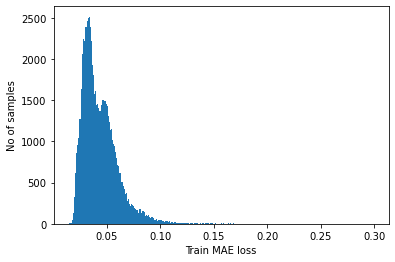

Reconstruction error threshold:  0.2991225989435309


In [24]:
x_train_pred = model.predict(X_train_normal)
train_mae_loss = np.mean(np.abs(x_train_pred - X_train_normal), axis=1)
plt.hist(train_mae_loss, bins='auto')
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

